In [1]:
!pip install lifelines

     |████████████████████████████████| 348kB 5.6MB/s 


### Creating baseline model for sepsis predictions

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

### Use 24 hr window observation, subset only for sepsis patients

In [3]:
sepsis = pd.read_csv('/content/drive/My Drive/Insight 2020/Sepsis Detection/24hr_windows.csv',index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
sepsis.head()

,index,PatientID,Delta_t_hours,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Sepsis_At_All,PatientID_Part,Hours
0,0,p000001,0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83,0,0.0,0.0,0.03,1,0,0,p000001 0,0
1,1,p000001,1,97.0,95.0,0.0,98.0,75.330,0.0,19.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83,0,0.0,0.0,0.03,2,0,0,p000001 0,1
2,2,p000001,2,89.0,99.0,0.0,122.0,86.000,0.0,22.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83,0,0.0,0.0,0.03,3,0,0,p000001 0,2
3,3,p000001,3,90.0,95.0,0.0,122.0,88.665,0.0,30.0,0.0,24.000000,0.0,0.00,7.360000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83,0,0.0,0.0,0.03,4,0,0,p000001 0,3
4,4,p000001,4,103.0,88.5,0.0,122.0,91.330,0.0,24.5,0.0,23.857143,0.0,0.28,7.365714,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83,0,0.0,0.0,0.03,5,0,0,p000001 0,4


In [5]:
len(sepsis['PatientID'].unique()),len(sepsis['PatientID_Part'].unique())

(29795, 644685)

In [6]:
len(sepsis['Hours'].unique())

24

In [7]:
#chose the right columns
columns = ['PatientID_Part', 'Hours','HR', 'O2Sat', 'Temp', 'SBP',
       'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH',
       'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride',
       'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium',
       'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb',
       'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1',
       'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Sepsis_At_All']
sepsis[columns].head()

,PatientID_Part,Hours,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Sepsis_At_All
0,p000001 0,0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83,0,0.0,0.0,0.03,1,0,0
1,p000001 0,1,97.0,95.0,0.0,98.0,75.330,0.0,19.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83,0,0.0,0.0,0.03,2,0,0
2,p000001 0,2,89.0,99.0,0.0,122.0,86.000,0.0,22.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83,0,0.0,0.0,0.03,3,0,0
3,p000001 0,3,90.0,95.0,0.0,122.0,88.665,0.0,30.0,0.0,24.000000,0.0,0.00,7.360000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83,0,0.0,0.0,0.03,4,0,0
4,p000001 0,4,103.0,88.5,0.0,122.0,91.330,0.0,24.5,0.0,23.857143,0.0,0.28,7.365714,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83,0,0.0,0.0,0.03,5,0,0


In [8]:
sepsis = sepsis[sepsis['Sepsis_At_All'] == 1][columns]
sepsis = sepsis.reset_index()
sepsis.head()

,index,PatientID_Part,Hours,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Sepsis_At_All
0,2880,p000009 0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,27,1,0.0,0.0,0.03,1,0,1
1,2881,p000009 0,1,117.0,99.0,0.0,116.0,97.0,81.0,20.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,27,1,0.0,0.0,0.03,2,0,1
2,2882,p000009 0,2,117.6,99.2,0.0,116.4,94.4,77.6,22.0,0.0,-7.0,23.0,0.0,7.15,66.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,3.6,0.0,0.0,4.0,0.0,0.0,37.6,12.70,46.4,8.900000,124.000000,64.000000,27,1,0.0,0.0,0.03,3,0,1
3,2883,p000009 0,3,118.2,99.4,0.0,116.8,91.8,74.2,24.0,0.0,-4.0,23.5,0.0,7.13,80.5,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.5,2.7,0.0,0.0,3.6,0.0,0.0,31.0,9.65,40.8,3.900000,180.000000,114.000000,27,1,0.0,0.0,0.03,4,0,1
4,2884,p000009 0,4,118.8,99.6,0.0,117.2,89.2,70.8,26.0,0.0,-1.0,24.0,0.0,7.30,52.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,3.8,0.0,0.0,3.6,0.0,0.0,28.0,9.30,39.8,4.033333,190.666667,115.333333,27,1,0.0,0.0,0.03,5,0,1


In [ ]:
sepsis.shape

(2731464, 45)

In [ ]:
sepsis.to_csv('/content/drive/My Drive/Insight 2020/Sepsis Detection/24hr_windows_sep_only.csv')

In [11]:
sepsis = pd.read_csv('/content/drive/My Drive/Insight 2020/Sepsis Detection/24hr_windows_sep_only.csv',index_col = 0)
sepsis.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,index,PatientID_Part,Hours,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Sepsis_At_All
0,2880,p000009 0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,27,1,0.0,0.0,0.03,1,0,1
1,2881,p000009 0,1,117.0,99.0,0.0,116.0,97.0,81.0,20.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,27,1,0.0,0.0,0.03,2,0,1
2,2882,p000009 0,2,117.6,99.2,0.0,116.4,94.4,77.6,22.0,0.0,-7.0,23.0,0.0,7.15,66.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,3.6,0.0,0.0,4.0,0.0,0.0,37.6,12.70,46.4,8.900000,124.000000,64.000000,27,1,0.0,0.0,0.03,3,0,1
3,2883,p000009 0,3,118.2,99.4,0.0,116.8,91.8,74.2,24.0,0.0,-4.0,23.5,0.0,7.13,80.5,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.5,2.7,0.0,0.0,3.6,0.0,0.0,31.0,9.65,40.8,3.900000,180.000000,114.000000,27,1,0.0,0.0,0.03,4,0,1
4,2884,p000009 0,4,118.8,99.6,0.0,117.2,89.2,70.8,26.0,0.0,-1.0,24.0,0.0,7.30,52.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,3.8,0.0,0.0,3.6,0.0,0.0,28.0,9.30,39.8,4.033333,190.666667,115.333333,27,1,0.0,0.0,0.03,5,0,1


In [12]:
sepsis['SepsisLabel'].value_counts()

0    2658480
1      72984
Name: SepsisLabel, dtype: int64

In [ ]:
sepsis.iloc[:,2:-1].head()

,Hours,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,27,1,0.0,0.0,0.03,1,0
1,1,117.0,99.0,0.0,116.0,97.0,81.0,20.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,27,1,0.0,0.0,0.03,2,0
2,2,117.6,99.2,0.0,116.4,94.4,77.6,22.0,0.0,-7.0,23.0,0.0,7.15,66.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,3.6,0.0,0.0,4.0,0.0,0.0,37.6,12.70,46.4,8.900000,124.000000,64.000000,27,1,0.0,0.0,0.03,3,0
3,3,118.2,99.4,0.0,116.8,91.8,74.2,24.0,0.0,-4.0,23.5,0.0,7.13,80.5,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.5,2.7,0.0,0.0,3.6,0.0,0.0,31.0,9.65,40.8,3.900000,180.000000,114.000000,27,1,0.0,0.0,0.03,4,0
4,4,118.8,99.6,0.0,117.2,89.2,70.8,26.0,0.0,-1.0,24.0,0.0,7.30,52.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,3.8,0.0,0.0,3.6,0.0,0.0,28.0,9.30,39.8,4.033333,190.666667,115.333333,27,1,0.0,0.0,0.03,5,0


In [ ]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(sepsis.iloc[:,2:-1],
        duration_col='Hours', 
        event_col='SepsisLabel',
       show_progress=True,step_size=.01)

Iteration 1: norm_delta = 0.38710, step_size = 0.0100, log_lik = -926675.91518, newton_decrement = 4248.18091, seconds_since_start = 1.7
Iteration 2: norm_delta = 0.38277, step_size = 0.0100, log_lik = -926591.37657, newton_decrement = 4158.18833, seconds_since_start = 3.4
Iteration 3: norm_delta = 0.37849, step_size = 0.0100, log_lik = -926508.62880, newton_decrement = 4070.21583, seconds_since_start = 5.1
Iteration 4: norm_delta = 0.37301, step_size = 0.0130, log_lik = -926403.49143, newton_decrement = 3958.59544, seconds_since_start = 6.9
Iteration 5: norm_delta = 0.36603, step_size = 0.0169, log_lik = -926270.82229, newton_decrement = 3817.99767, seconds_since_start = 8.5
Iteration 6: norm_delta = 0.35717, step_size = 0.0220, log_lik = -926104.90393, newton_decrement = 3642.56752, seconds_since_start = 10.2
Iteration 7: norm_delta = 0.34601, step_size = 0.0286, log_lik = -925899.80771, newton_decrement = 3426.35046, seconds_since_start = 11.9
Iteration 8: norm_delta = 0.33209, step

<lifelines.CoxPHFitter: fitted with 2.73146e+06 total observations, 2.65848e+06 right-censored observations>

In [ ]:
cph.predict_survival_function(sepsis.iloc[18,1:-2]).values.ravel()[0]

1.0

In [ ]:
cph.print_summary()

In [ ]:
cph.summary.sort_values('p')

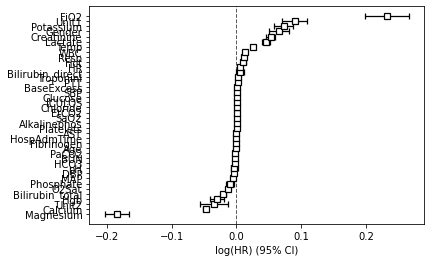

In [ ]:
cph.plot()

In [ ]:
plt.plot(range(0,24),cph.predict_survival_function(sepsis.iloc[5593,1:-2]))

In [ ]:
sepsis[sepsis['PatientID_Part'] == 'p000009 233']

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

In [ ]:
## Now go throug the all the training examples, making sure to get accuracy, precision, and recall
#but you are going to have to do this for each time point
#so for each observation i can get the tpr, fpr,
def get_metrics_by_timepoint(model,actual,input,threshold=0.05):
  probas = model.predict_survival_function(input).values.ravel()
  probas = 1 - probas
  actuals = [actual for i in range(24)]
  predictions = probas > threshold
  return precision_score(actuals,predictions),recall_score(actuals,predictions),f1_score(actuals, predictions),probas

In [ ]:
get_metrics_by_timepoint(cph,1,sepsis.iloc[8956,1:-2])

(1.0,
 0.16666666666666666,
 0.2857142857142857,
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00124341, 0.00453962, 0.0104162 , 0.01963695, 0.03339816,
        0.05369505, 0.08437862, 0.13453572, 0.2372139 ]))

In [ ]:
sepsis = sepsis.sample(frac=1)
sepsis.head()

,index,PatientID_Part,Hours,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Sepsis_At_All
1212389,5928941,p015338 5,5,98.000000,100.0,38.720000,122.000000,79.000000,63.000000,19.000,0.0,-1.153846,22.695652,0.400,7.364615,43.461538,0.000000,0.000000,13.956522,0.000000,8.552174,106.086957,1.073913,0.0,136.956522,2.000000,1.834783,2.478261,4.086957,0.000000,0.0,37.330435,13.352174,22.373913,14.317391,0.0,182.826087,29,1,0.0,0.0,0.02,12,0,1
667900,3341188,p008638 52,4,94.214286,98.5,36.547500,146.928571,104.428571,82.714286,15.375,0.0,2.000000,26.769231,0.475,7.420333,40.933333,97.087719,31.892562,7.230769,58.694215,8.023077,101.230769,0.600000,0.0,110.538462,1.053191,1.892308,2.953846,3.545455,0.985124,0.0,36.415385,12.253846,26.700000,9.738462,0.0,120.615385,42,1,1.0,0.0,0.02,58,0,1
2151145,11527825,p109702 15,1,92.000000,96.5,36.281818,94.000000,72.000000,61.000000,23.000,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,20.360000,26.636364,77.720000,7.981818,0.000000,1.109091,0.2,66.727273,0.000000,2.036364,0.000000,3.900000,1.000000,0.0,34.118182,10.672727,0.000000,9.872727,0.0,256.272727,100,1,1.0,0.0,4.69,17,0,1
1989067,10344235,p106498 50,19,97.000000,98.0,37.250000,154.000000,94.000000,73.000000,22.000,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,34.561644,11.000000,81.273973,7.936000,0.000000,0.650000,0.0,97.833333,0.000000,1.704000,4.072000,4.076000,0.424658,0.0,32.656000,10.004000,0.000000,17.820000,0.0,267.800000,61,1,1.0,0.0,110.16,70,0,1
256706,1174226,p003010 18,2,69.000000,99.0,37.300000,105.000000,71.000000,52.000000,6.000,0.0,-0.857143,22.000000,0.600,7.377143,41.857143,97.142857,0.000000,47.428571,0.000000,8.206667,114.142857,1.442857,0.0,115.333333,0.000000,1.857143,3.860000,4.928571,0.000000,0.0,30.400000,9.516667,24.873077,11.466667,0.0,205.333333,57,0,1.0,0.0,144.24,21,0,1


In [ ]:
#another way
#call the estimator for all the samples and return for each timepoint
#for each timepoint i can get the folloinwg metrics
def get_metrics_at_timepoint(model,data,time,sample_size,threshold=0.5):
  data = data.iloc[:sample_size,:]
  probas = np.zeros((len(data)))
  actuals = sepsis['SepsisLabel'].values[:len(data)]
  predictions = probas > threshold
  for i in range(0,len(data)):
    probas[i] = (1-model.predict_survival_function(data.iloc[i,1:-2]).values.ravel()[time])
  return accuracy_score(actuals,predictions),precision_score(actuals,predictions),recall_score(actuals,predictions),f1_score(actuals, predictions),roc_auc_score(actuals,probas)



In [ ]:
get_metrics_at_timepoint(cph,sepsis,13,5000)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.974, 0.0, 0.0, 0.0, 0.5)

In [ ]:
import time
print(time.ctime())

Tue Sep 29 05:51:54 2020


In [ ]:
all_metrics = []
for t in range(0,24):
  print(t,time.ctime())
  a,p,r,f,auc = get_metrics_at_timepoint(cph,sepsis,t,50000)
  all_metrics.append((a,p,r,f,auc))

0 Tue Sep 29 06:11:37 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1 Tue Sep 29 06:22:39 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2 Tue Sep 29 06:33:39 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3 Tue Sep 29 06:44:42 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4 Tue Sep 29 06:55:42 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5 Tue Sep 29 07:06:42 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6 Tue Sep 29 07:17:42 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7 Tue Sep 29 07:28:40 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8 Tue Sep 29 07:39:41 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9 Tue Sep 29 07:50:40 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10 Tue Sep 29 08:01:37 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11 Tue Sep 29 08:12:35 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12 Tue Sep 29 08:23:34 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13 Tue Sep 29 08:34:31 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14 Tue Sep 29 08:45:29 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15 Tue Sep 29 08:56:25 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16 Tue Sep 29 09:07:24 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


17 Tue Sep 29 09:18:22 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18 Tue Sep 29 09:29:22 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


19 Tue Sep 29 09:40:22 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20 Tue Sep 29 09:51:23 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


21 Tue Sep 29 10:02:24 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


22 Tue Sep 29 10:13:22 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


23 Tue Sep 29 10:24:25 2020


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
all_metrics

[(0.974, 0.0, 0.0, 0.0, 0.5), (0.974, 0.0, 0.0, 0.0, 0.5)]

In [ ]:
import pickle
pickle.dump(cph, open('/content/drive/My Drive/Insight 2020/Sepsis Detection/Cox_Model_v1.sav', 'wb'))

In [ ]:
loaded_model = pickle.load(open('/content/drive/My Drive/Insight 2020/Sepsis Detection/Cox_Model_v1.sav', 'rb'))

In [ ]:
del loaded_model

In [ ]:
sepsis.head()

,index,PatientID_Part,Hours,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Sepsis_At_All
0,2880,p000009 0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,27,1,0.0,0.0,0.03,1,0,1
1,2881,p000009 0,1,117.0,99.0,0.0,116.0,97.0,81.0,20.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,27,1,0.0,0.0,0.03,2,0,1
2,2882,p000009 0,2,117.6,99.2,0.0,116.4,94.4,77.6,22.0,0.0,-7.0,23.0,0.0,7.15,66.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,3.6,0.0,0.0,4.0,0.0,0.0,37.6,12.70,46.4,8.900000,124.000000,64.000000,27,1,0.0,0.0,0.03,3,0,1
3,2883,p000009 0,3,118.2,99.4,0.0,116.8,91.8,74.2,24.0,0.0,-4.0,23.5,0.0,7.13,80.5,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.5,2.7,0.0,0.0,3.6,0.0,0.0,31.0,9.65,40.8,3.900000,180.000000,114.000000,27,1,0.0,0.0,0.03,4,0,1
4,2884,p000009 0,4,118.8,99.6,0.0,117.2,89.2,70.8,26.0,0.0,-1.0,24.0,0.0,7.30,52.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,3.8,0.0,0.0,3.6,0.0,0.0,28.0,9.30,39.8,4.033333,190.666667,115.333333,27,1,0.0,0.0,0.03,5,0,1
